# Adding bias to the minimal model
This is a further investigation into observe the behavior of a minimal model. We observed in the experiment `10. initial_bias`, that adding a bias to ReLu-activation functions can supress immediate compression. So by adding a bias one could show, that ReLu compresses. 

In this notebook this behavior is recreated for a minimal model. The behavior of the mininmal model with a ReLu- and TanH-activation function can be observed for adding different biases.

In [1]:
import numpy as np
np.random.seed(0)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [2]:
weights = np.arange(0.1, 8, 0.1)

In [3]:
weights

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9])

The input is sampled from a standard normal distribution.

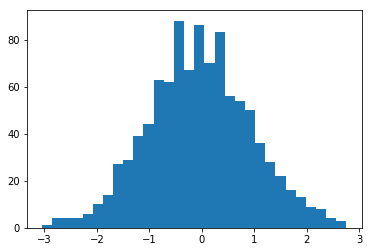

In [4]:
input_distribution = stats.norm()
input_ = input_distribution.rvs(1000)
plt.hist(input_, bins=30);

The input is multiplied by the different weights. This is the pass from the input neuron to the hidden neuron.

In [5]:
net_input = np.outer(weights, input_)

The activation functions we want to test.

In [6]:
activation_functions = [tf.nn.tanh, tf.nn.relu]

Apply the activation functions to the weighted inputs.

In [7]:
outputs = {}
for actvation_function in activation_functions:
    try:
        outputs[actvation_function.__name__] = actvation_function(net_input).numpy()
    except AttributeError:
        outputs[actvation_function.__name__] = actvation_function(net_input)

We now estimate the discrete mututal information between the input $X$ and the activity of the hidden neuron $Y$, which is in this case also the output. $H(Y|X) = 0$, since $Y$ is a deterministic function of $X$. Therefore

\begin{align}
I(X;Y) &= H(Y) - H(Y|X)\\
       &= H(Y)\\
\end{align}

The entropy of the input is 

In [8]:
dig, _ = np.histogram(input_, 50)
print(f'{stats.entropy(dig, base=2):.2f} bits')

5.11 bits


The bias values are

In [9]:
bias_values = [0, 1, 2, 3, 4, 5]

To the input for every activation function a bias is added.

In [11]:
outputs_with_bias = {}
for bias_value in bias_values:
    outputs = {}
    for actvation_function in activation_functions:
        try:
            net_input_bias = net_input + bias_value
            outputs[actvation_function.__name__] = actvation_function(net_input_bias).numpy()
        except AttributeError:
            net_input_bias = net_input + bias_value
            outputs[actvation_function.__name__] = actvation_function(net_input_bias)
        
        outputs_with_bias[bias_value] = outputs 

In [13]:
dig, _ = np.histogram(input_, 50)
print(f'{stats.entropy(dig, base=2):.2f} bits')

5.11 bits


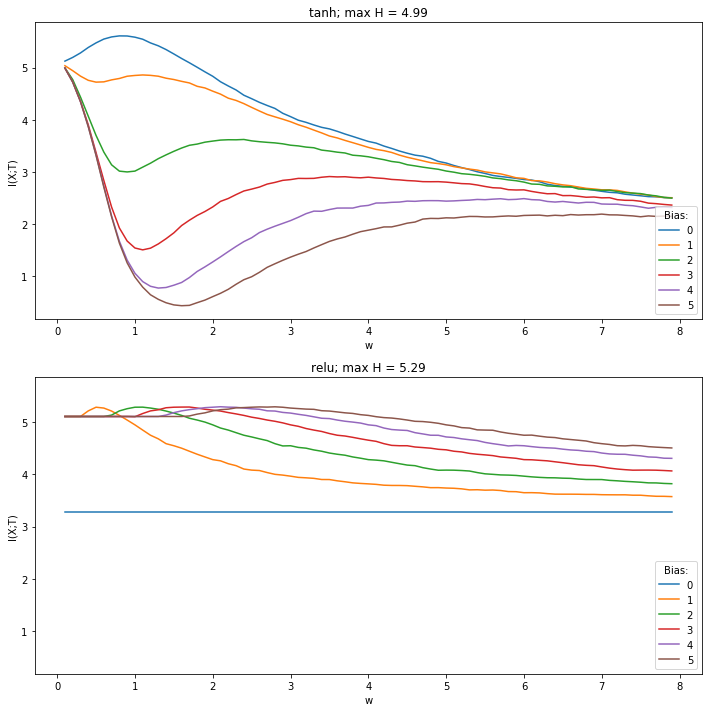

In [14]:
fig, ax = plt.subplots(nrows=len(activation_functions), figsize=(10, 10), sharey=True)
ax = ax.flat
for bias_value in bias_values:
    for ax_idx, (activation_function, Y) in enumerate(outputs_with_bias[bias_value].items()):

        mi = np.zeros(len(weights))
        for i in range(len(weights)):
            digitized, _ = np.histogram(Y[i], bins=50)
            mi[i] = stats.entropy(digitized, base=2) 

        ax[ax_idx].plot(weights,  mi)
        ax[ax_idx].legend(bias_values,loc='lower right',title='Bias:')
        ax[ax_idx].set(title=f'{activation_function}; max H = {mi.max():.2f}', xlabel='w', ylabel='I(X;T)') 
    
plt.tight_layout()
plt.show()